In [ ]:
!pip install torch torchvision transformers timm pillow matplotlib opencv-python tensorflow-hub tensorflow
!pip install huggingface_hub sentence-transformers ftfy regex tqdm
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.6.0+cu124
CUDA available: False


### 1. CLIP: Contrastive Language-Image Pre-training
CLIP by OpenAI excels at connecting images with natural language, making it powerful for zero-shot image classification and retrieval tasks.
Business Applications:
Product image search and recommendation,
Content moderation,
Visual brand monitoring,
Cross-modal retrieval systems

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

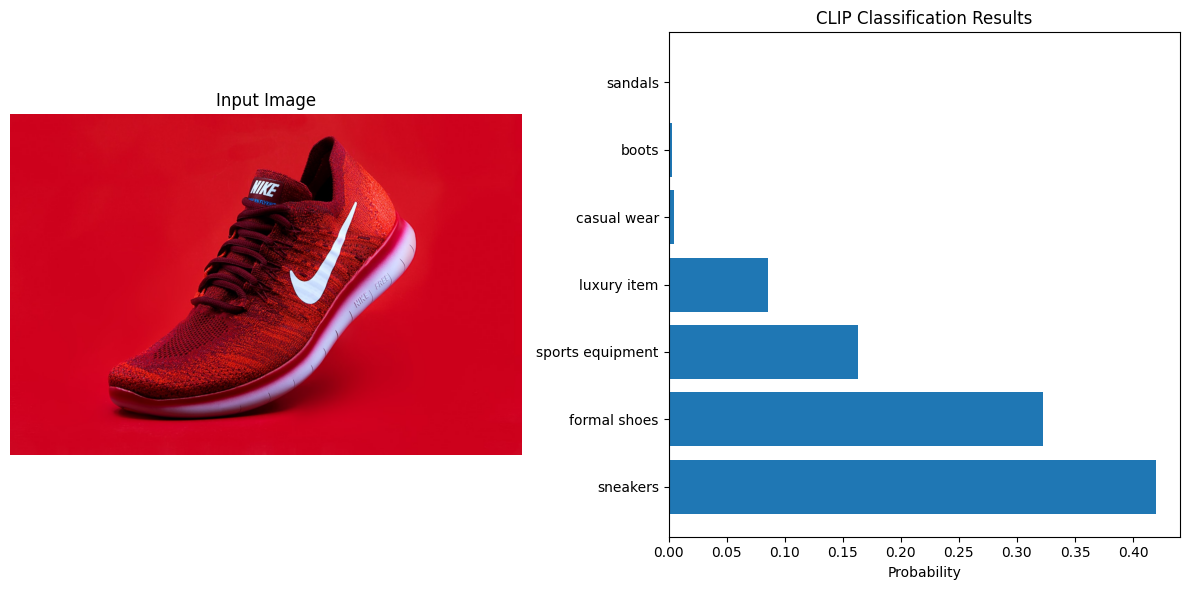

Classification Results:
sneakers: 0.4195
formal shoes: 0.3226
sports equipment: 0.1632
luxury item: 0.0858
casual wear: 0.0049
boots: 0.0026
sandals: 0.0013


In [ ]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import numpy as np

# Load model and processor
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

# Function to get image embeddings
def get_clip_image_embedding(image_path):
    image = Image.open(image_path) if isinstance(image_path, str) else image_path
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features

# Function to perform zero-shot classification
def classify_image_with_clip(image_path, categories):
    image = Image.open(image_path) if isinstance(image_path, str) else image_path
    inputs = processor(
        text=categories,
        images=image,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    # Return dict of categories and probabilities
    return {categories[i]: probs[0][i].item() for i in range(len(categories))}

# Example: Product categorization
url = "https://images.unsplash.com/photo-1542291026-7eec264c27ff?q=80&w=1470&auto=format&fit=crop"
image = Image.open(requests.get(url, stream=True).raw)

product_categories = [
    "sneakers", "formal shoes", "sandals", "boots",
    "sports equipment", "casual wear", "luxury item"
]

results = classify_image_with_clip(image, product_categories)

# Sort results by probability
sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

# Display the image and classification results
plt.figure(figsize=(12, 6))

# Plot the image on the left
plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.title("Input Image")
plt.axis("off")

# Plot the classification results on the right
plt.subplot(1, 2, 2)
categories = list(sorted_results.keys())
scores = list(sorted_results.values())

y_pos = np.arange(len(categories))
plt.barh(y_pos, scores, align="center")
plt.yticks(y_pos, categories)
plt.xlabel("Probability")
plt.title("CLIP Classification Results")

plt.tight_layout()
plt.show()

# Also print results to console
print("Classification Results:")
for category, score in sorted_results.items():
    print(f"{category}: {score:.4f}")

### 2. DINO v2: Self-supervised Vision Transformer
DINO v2 by Meta AI Research provides powerful visual features without requiring labeled data, making it excellent for various downstream tasks.

Business Applications:
Visual similarity search,
Anomaly detection,
Product clustering,
Image feature extraction for downstream ML tasks



Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 216MB/s]


Comparing Product 1 and Product 2:


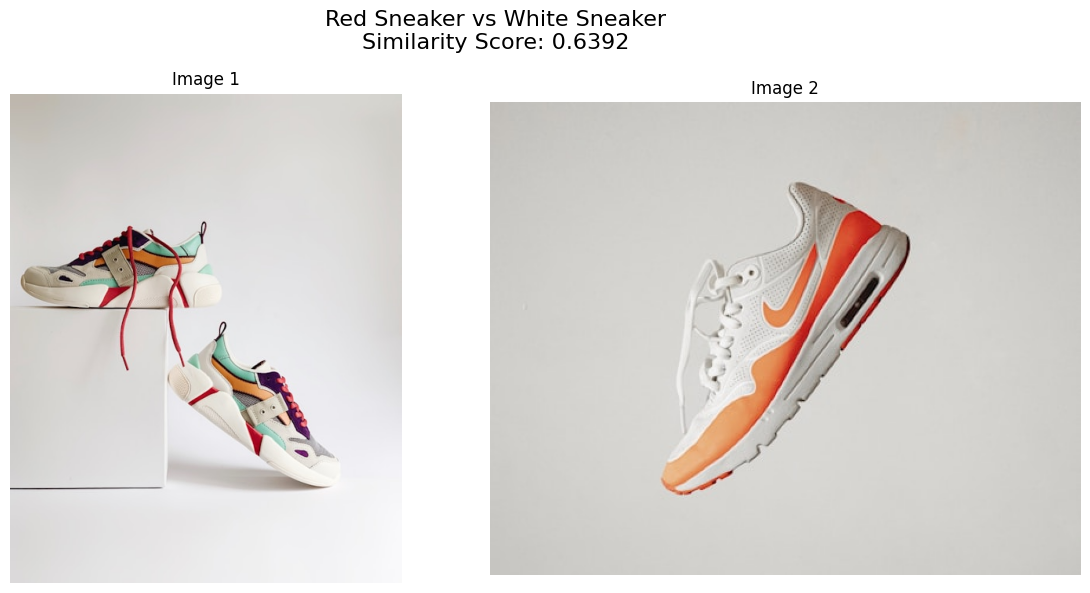


Comparing Product 1 and Product 3:


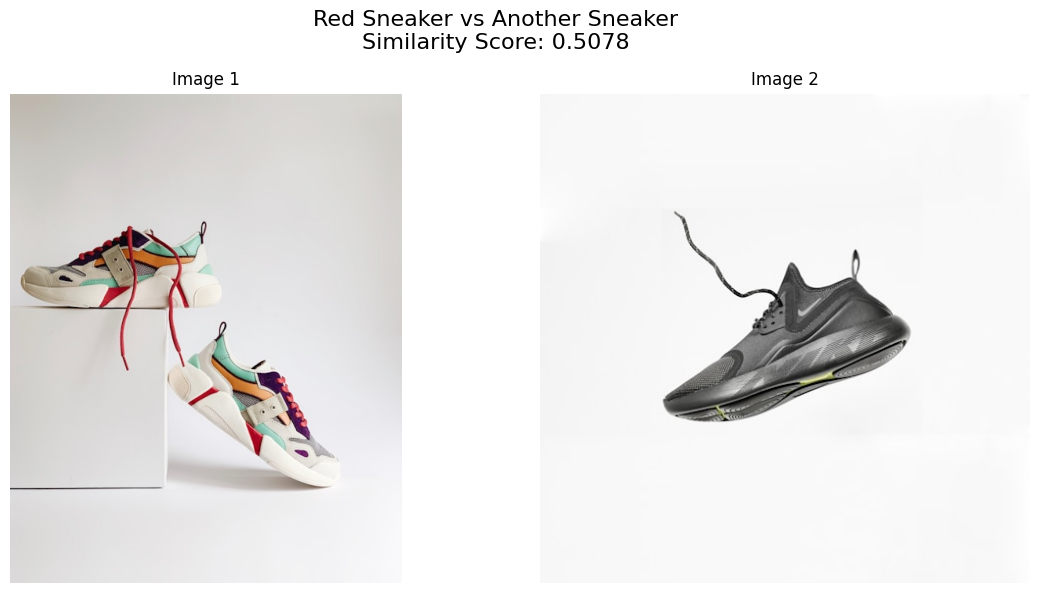


Comparing Product 2 and Product 3:


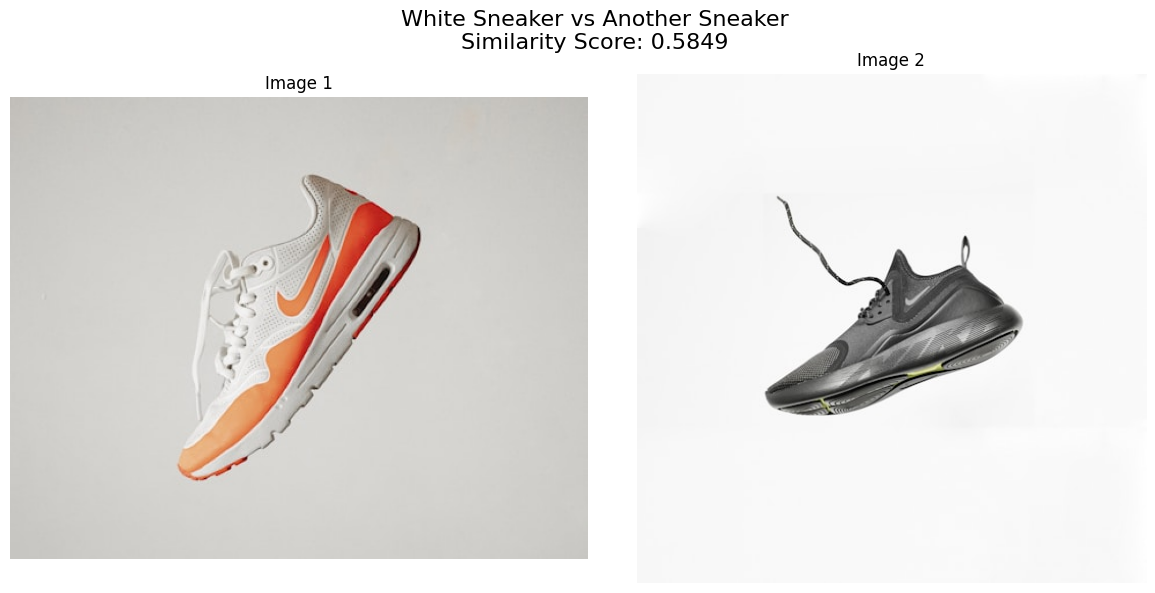


Summary of Similarity Scores:
Similarity between product 1 and 2: 0.6392
Similarity between product 1 and 3: 0.5078
Similarity between product 2 and 3: 0.5849


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import requests
from io import BytesIO

# Load DINOv2 model
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()

# Preprocess images for DINOv2
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features
def extract_dinov2_features(image_path):
    image = Image.open(image_path).convert('RGB') if isinstance(image_path, str) else image_path
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        features = dinov2_vits14(img_tensor)

    return features

# Function to compute similarity between images
def compute_similarity(img1_path, img2_path):
    feat1 = extract_dinov2_features(img1_path)
    feat2 = extract_dinov2_features(img2_path)

    # Normalize features
    feat1 = F.normalize(feat1, dim=1)
    feat2 = F.normalize(feat2, dim=1)

    # Compute cosine similarity
    similarity = torch.mm(feat1, feat2.transpose(0, 1)).item()
    return similarity

# Function to download image from URL
def download_image(url):
    response = requests.get(url, stream=True)
    return Image.open(BytesIO(response.content)).convert('RGB')

# Function to visualize image pair with similarity score
def visualize_similarity(img1_path, img2_path, title=None):
    # Load images
    if img1_path.startswith(('http://', 'https://')):
        img1 = download_image(img1_path)
    else:
        img1 = Image.open(img1_path).convert('RGB')

    if img2_path.startswith(('http://', 'https://')):
        img2 = download_image(img2_path)
    else:
        img2 = Image.open(img2_path).convert('RGB')

    # Compute similarity
    similarity = compute_similarity(img1, img2)

    # Create figure for visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display images
    axes[0].imshow(np.array(img1))
    axes[0].set_title("Image 1")
    axes[0].axis("off")

    axes[1].imshow(np.array(img2))
    axes[1].set_title("Image 2")
    axes[1].axis("off")

    # Add similarity score as figure title
    fig_title = f"Similarity Score: {similarity:.4f}"
    if title:
        fig_title = f"{title}\n{fig_title}"
    fig.suptitle(fig_title, fontsize=16)

    plt.tight_layout()
    plt.show()

    return similarity

# Example: Use direct URLs instead of downloading files first
# Sample sneaker images from Unsplash
url1 = "https://images.unsplash.com/photo-1560769629-975ec94e6a86?w=500"  # Red sneaker
url2 = "https://images.unsplash.com/photo-1600185365926-3a2ce3cdb9eb?w=500"  # White sneaker
url3 = "https://images.unsplash.com/photo-1491553895911-0055eca6402d?w=500"  # Another sneaker

# Visualize pairs with similarity scores
print("Comparing Product 1 and Product 2:")
similarity_1_2 = visualize_similarity(url1, url2, "Red Sneaker vs White Sneaker")

print("\nComparing Product 1 and Product 3:")
similarity_1_3 = visualize_similarity(url1, url3, "Red Sneaker vs Another Sneaker")

print("\nComparing Product 2 and Product 3:")
similarity_2_3 = visualize_similarity(url2, url3, "White Sneaker vs Another Sneaker")

# Print summary of all similarities
print("\nSummary of Similarity Scores:")
print(f"Similarity between product 1 and 2: {similarity_1_2:.4f}")
print(f"Similarity between product 1 and 3: {similarity_1_3:.4f}")
print(f"Similarity between product 2 and 3: {similarity_2_3:.4f}")

### 3. Segment Anything Model (SAM): Advanced Image Segmentation
SAM by Meta AI provides powerful zero-shot segmentation capabilities for various business applications.

Business Applications:
Precise product measurement in retail,
Medical image analysis,
Agricultural crop monitoring,
Content creation and editing,
Automated image cataloging.


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gdnigueu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gdnigueu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=6dcaabb9184d876791aecda0f88885d79aa1e2d19c5f4fc80b8798ccce3e7e5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-umugemjg/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


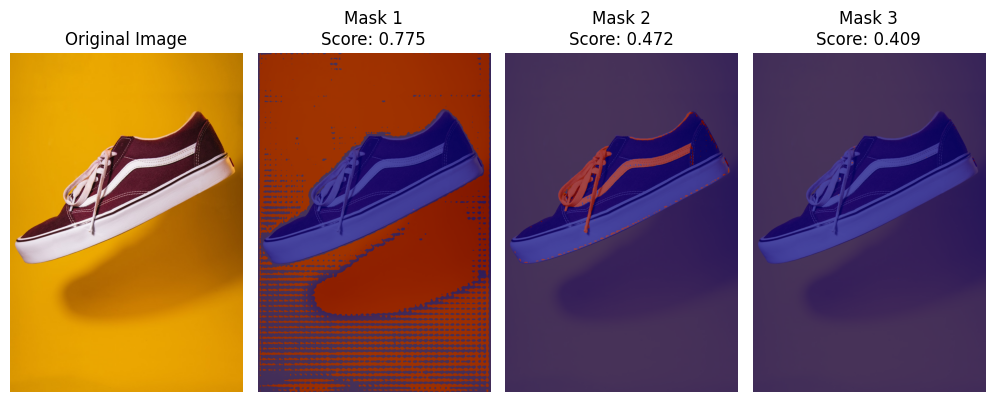

Product Dimensions:
Width: 790 pixels
Height: 1133 pixels
Aspect Ratio: 0.70
Area: 565432.0 square pixels


In [ ]:
# Install required libraries for SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import cv2
from PIL import Image
import requests

# Download SAM checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Load SAM model
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)
predictor = SamPredictor(sam)

# Function to perform automatic segmentation
def segment_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set image for SAM
    predictor.set_image(image_rgb)

    # Generate automatic masks
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        multimask_output=True,
        box=None
    )

    return image_rgb, masks, scores

# Function to visualize segmentation results
def visualize_segmentation(image, masks, scores, limit=5):
    plt.figure(figsize=(15, 10))

    # Display original image
    plt.subplot(1, limit+1, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Display top masks
    top_indices = np.argsort(scores)[-limit:][::-1]
    for i, idx in enumerate(top_indices):
        plt.subplot(1, limit+1, i+2)
        plt.imshow(image)
        plt.imshow(masks[idx], alpha=0.7, cmap='jet')
        plt.title(f"Mask {i+1}\nScore: {scores[idx]:.3f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: Product segmentation for e-commerce
!wget -q -O product_image.jpg "https://images.unsplash.com/photo-1525966222134-fcfa99b8ae77?w=800"

image_rgb, masks, scores = segment_image("product_image.jpg")
visualize_segmentation(image_rgb, masks, scores)

# Business application: Calculate precise product measurements
def calculate_object_dimensions(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours((mask * 255).astype(np.uint8),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate aspect ratio
    aspect_ratio = w / h

    # Calculate area in pixels
    area_pixels = cv2.contourArea(largest_contour)

    return {
        'width': w,
        'height': h,
        'aspect_ratio': aspect_ratio,
        'area_pixels': area_pixels
    }

# Apply to the highest scoring mask
best_mask_idx = np.argmax(scores)
dimensions = calculate_object_dimensions(masks[best_mask_idx])

print("Product Dimensions:")
print(f"Width: {dimensions['width']} pixels")
print(f"Height: {dimensions['height']} pixels")
print(f"Aspect Ratio: {dimensions['aspect_ratio']:.2f}")
print(f"Area: {dimensions['area_pixels']} square pixels")


### 4. BLIP-2: Vision-Language Model for Business Intelligence
BLIP-2 provides advanced vision-language capabilities for multimodal business applications.
Business Applications:
Automated product description generation
Image-based customer service automation
Visual content analysis for marketing
Social media content understanding



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

1. Basic Product Analysis


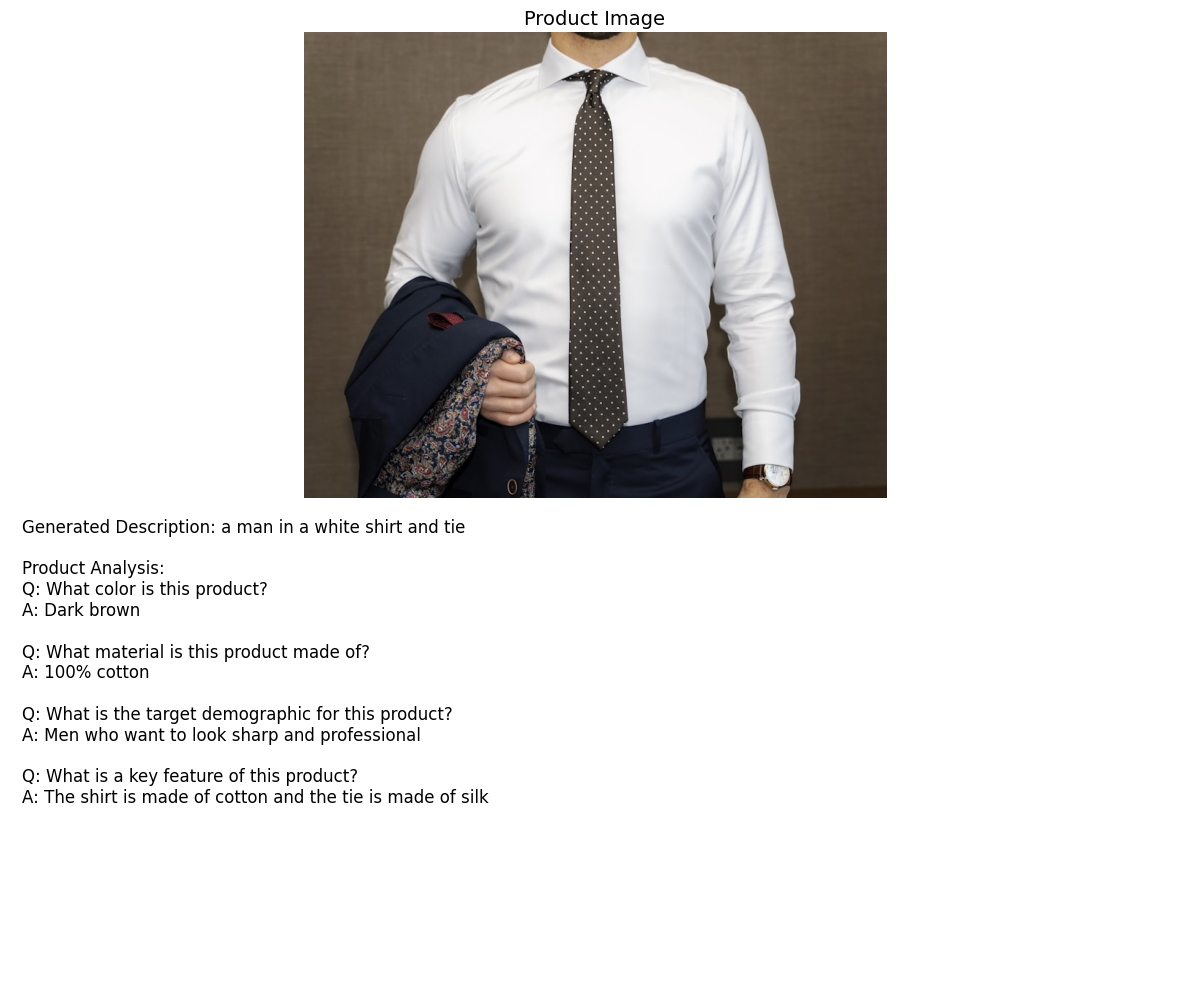


2. Creating Automated Product Listing


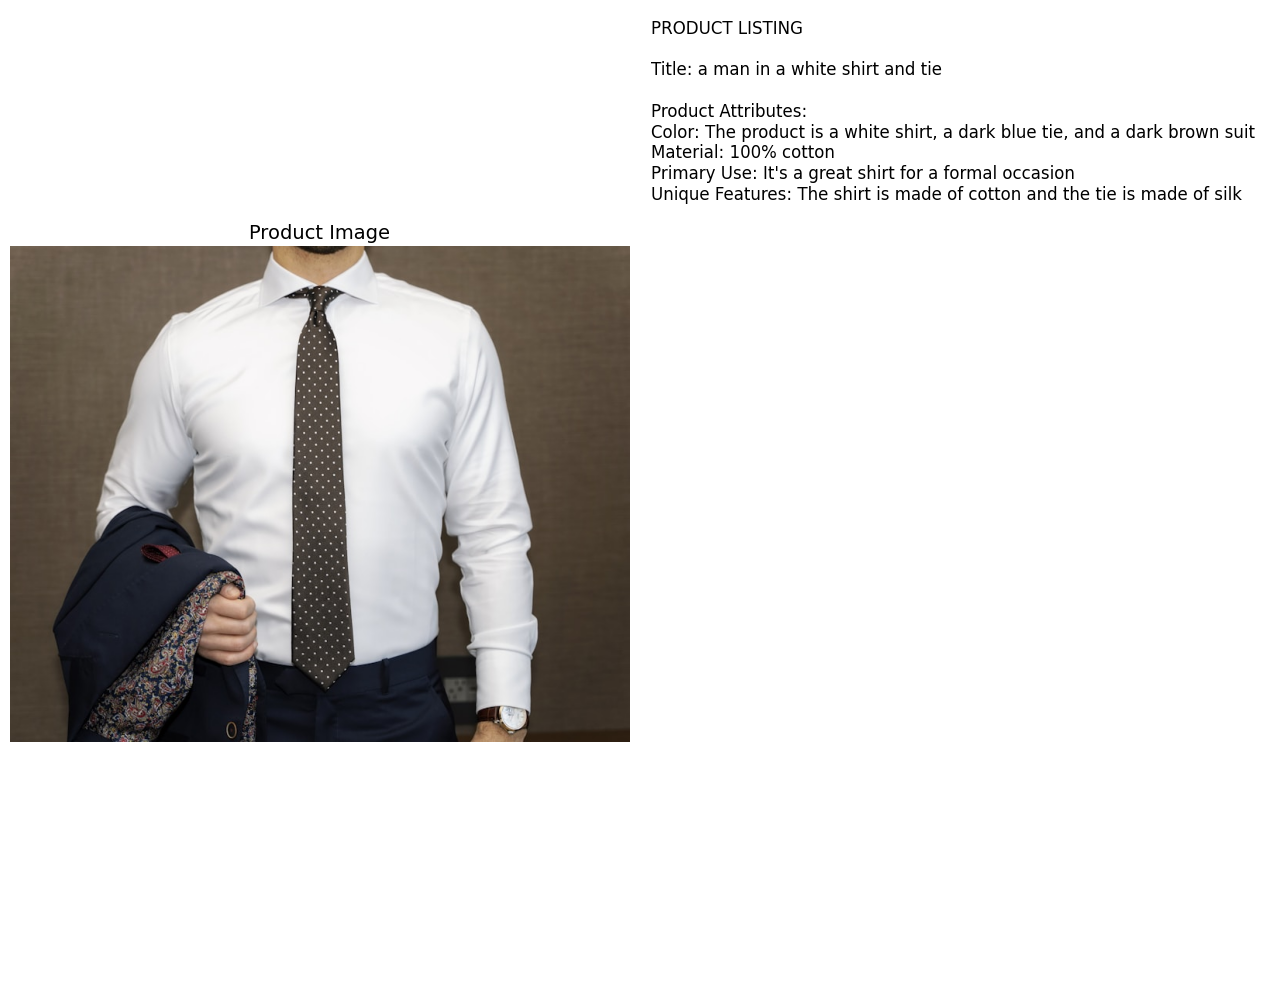

In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

if torch.cuda.is_available():
    model = model.to("cuda")

def download_image(url):
    response = requests.get(url, stream=True)
    return Image.open(BytesIO(response.content)).convert('RGB')

def generate_caption(image_path):
    if isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            image = download_image(image_path)
        else:
            image = Image.open(image_path).convert('RGB')
    else:
        image = image_path

    inputs = processor(images=image, return_tensors="pt")

    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    generated_ids = model.generate(**inputs, max_new_tokens=50)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

def visual_qa(image_path, question):
    if isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            image = download_image(image_path)
        else:
            image = Image.open(image_path).convert('RGB')
    else:
        image = image_path

    prompt = f"Question: {question} Answer:"
    inputs = processor(images=image, text=prompt, return_tensors="pt")

    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    generated_ids = model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=False
    )

    answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    answer = answer.replace(prompt, "").strip()

    return answer

def visualize_product_analysis(image_path, questions=None):
    if isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            image = download_image(image_path)
        else:
            image = Image.open(image_path).convert('RGB')
    else:
        image = image_path

    caption = generate_caption(image)

    if questions is None:
        questions = [
            "What color is this product?",
            "What material is this product made of?",
            "What is the target demographic for this product?",
            "What is a key feature of this product?"
        ]

    answers = []
    for question in questions:
        answer = visual_qa(image, question)
        answers.append((question, answer))

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(np.array(image))
    plt.title("Product Image", fontsize=14)
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.axis('off')

    text_content = f"Generated Description: {caption}\n\n"
    text_content += "Product Analysis:\n"
    for q, a in answers:
        text_content += f"Q: {q}\nA: {a}\n\n"

    plt.text(0.01, 0.99, text_content, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', wrap=True)

    plt.tight_layout()
    plt.show()

    return caption, answers

def create_product_listing(image_path):
    if isinstance(image_path, str):
        if image_path.startswith(('http://', 'https://')):
            image = download_image(image_path)
        else:
            image = Image.open(image_path).convert('RGB')
    else:
        image = image_path


    caption = generate_caption(image)


    color = visual_qa(image, "What colors are visible in this product?")
    material = visual_qa(image, "What material does this product appear to be made of?")
    use_case = visual_qa(image, "What would be the main use case for this product?")
    unique_features = visual_qa(image, "What are any unique or notable features of this product?")


    listing = {
        "title": caption,
        "attributes": {
            "color": color,
            "material": material,
            "primary_use": use_case,
            "unique_features": unique_features
        }
    }


    plt.figure(figsize=(14, 10))


    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image))
    plt.title("Product Image", fontsize=14)
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.axis('off')

    listing_text = f"PRODUCT LISTING\n\n"
    listing_text += f"Title: {listing['title']}\n\n"
    listing_text += "Product Attributes:\n"
    for attr, value in listing['attributes'].items():
        listing_text += f"{attr.replace('_', ' ').title()}: {value}\n"

    plt.text(0.01, 0.99, listing_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

    return listing

if __name__ == "__main__":
    product_url = "https://images.unsplash.com/photo-1598033129183-c4f50c736f10?w=800"

    print("1. Basic Product Analysis")
    caption, qa_results = visualize_product_analysis(product_url)

    print("\n2. Creating Automated Product Listing")
    product_listing = create_product_listing(product_url)


###Thank You!